# Machine Learning for prediction of Heart Disease

| Feature         | Description                                                  | Type
| ---             | ---                                                          | ---                                    
| **age**         | Age                                                          | Real
| **sex**         | Sex                                                          | Binary
| **cp**          | Chest pain type (4 values)                                   | Nominal
| **trestbps**    | Resting blood age                                            | Real
| **chol**        | Serum cholesterol (in mg/dl)                                 | Real
| **fbs**         | Fasting blood sugar > 120 mg/dl                              | Binary
| **restecg**     | Resting electrocardiographic results (values 0,1,2)          | Nominal
| **thalach**     | Maximum heart rate achieved                                  | Real
| **exang**       | Exercise induced angina                                      | Binary
| **oldpeak**     | Oldpeak = ST depression induced by exercise relative to rest | Real
| **slope**       | The slope of the peak exercise ST segment                    | Ordered
| **ca**          | Number of major vessels (0-3) colored by flouroscopy         | Real
| **thal**        | Thal: 3 = normal; 6 = fixed defect; 7 = reversable defect    | Nominal
| **target**      | 1 = no disease; 2 = presence of disease                      | 

In [202]:
import numpy as np
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

detail = {"age": "Age", "sex": "Sex", "cp": "Chest Pain Type", "trestbps": "Resting Blood Pressure",
          "chol": "Serum Cholesterol", "fbs": "Fasting Blood Sugar", "restecg": "Resting ECG",
          "thalach": "Max Heart Rate", "exang": "Exercise Induced Angina", "oldpeak": "Oldpeak",
          "slope": "Slope", "ca": "Number of major vessels", "thal": "Thal", "target": "(0 - no disease, 1 - disease))"}

sns.set_theme(context="paper", font_scale=1.5, style="whitegrid", palette="Set2")

data = pd.read_csv("heart.dat", sep="\\s+", header=None)
data.columns = detail.keys()

numericalFeatures = ["age", "trestbps", "chol", "thalach", "oldpeak", "ca"]
categoricalFeatures = ["sex", "cp", "fbs", "restecg", "exang", "slope", "thal"]

## Data Pre-Processing


In [203]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Check for missing values
print("Number of missing values:", data.isnull().sum().sum())
# Check for duplicates
print("Number of duplicates:", data.duplicated().sum())

X = data.iloc[:, :-1]
Y = data.iloc[:, -1] - 1
# print(data.describe())

# Removing extreme OUTLIERS (only 1) (3 * IQR below and above the Q1 and Q3, respectively)
Q1 = X[numericalFeatures].quantile(0.25)
Q3 = X[numericalFeatures].quantile(0.75)
IQR = Q3 - Q1

# Find the outlier row(s)
outlier_mask = ((X[numericalFeatures] < (Q1 - 3 * IQR)) | (X[numericalFeatures] > (Q3 + 3 * IQR))).any(axis=1)
# Remove the outlier row(s) from X
X = X[~outlier_mask]
Y = Y[~outlier_mask]

print("Number of outliers removed:", len(data) - len(X), '\n')

X_numerical = X[numericalFeatures]
X_categorical = X[categoricalFeatures]

# Apply SCALING only to numerical variables
# Standardizing
X_stand = X.copy()
X_stand[numericalFeatures] = StandardScaler().fit_transform(X_numerical)
# Normalizing
X_norm = X.copy()
X_norm[numericalFeatures] = MinMaxScaler().fit_transform(X_numerical)

# ONE HOT ENCODING
X_oneHot = pd.get_dummies(X, columns=["cp", "restecg", "slope", "thal"])
X_oneHot_stand = pd.get_dummies(X_stand, columns=["cp", "restecg", "slope", "thal"])
X_oneHot_norm = pd.get_dummies(X_norm, columns=["cp", "restecg", "slope", "thal"])


Number of missing values: 0
Number of duplicates: 0
Number of outliers removed: 1 



## Feature Correlation

### Heatmap

Although the heatmap should work better with numeric features, categorical binary ones are simple enough that a numeric relationship can apply to its categorical nature.
Features used:
- **numerical** - age, trestbps, chol, thalach, oldpeak, ca
- **categorical** - sex, fbs, exang

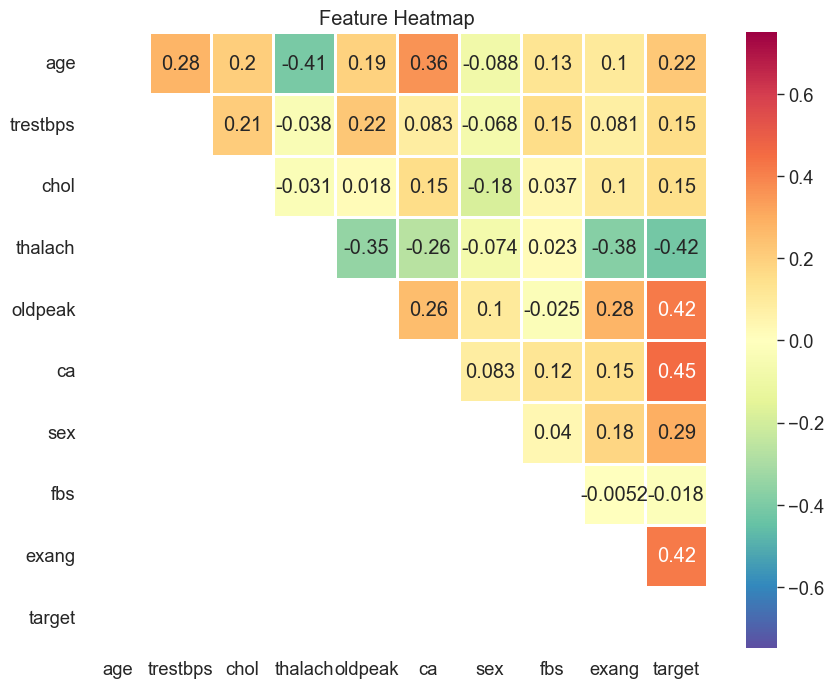

In [204]:
figsize = (10, 8)
vmin = -0.75
vmax = 0.75

X_heatmap = X[numericalFeatures + ["sex", "fbs", "exang"]].copy()

dataCorr = pd.concat([X_heatmap, data["target"]], axis=1).corr()

upperHalf_mask = np.tril(np.ones_like(dataCorr, dtype=bool))    # remove bottom left corner

plt.figure(figsize=figsize)
plt.title("Feature Heatmap")
sns.heatmap(dataCorr, annot=True, linewidths=2,
            mask=upperHalf_mask, cmap="Spectral_r", vmin=vmin, vmax=vmax
)
plt.savefig(f"plots/heatmap/heatmap.png")

By looking at **trestbps** density distribution and boxplot we can assess that it provides little information for the classification, as the distributions for disease and no disease are pratically overlapping.  

A slighter version of the same phenomenon happens for **chol**.  

The categorical feature **fbs** also appears to have little effect on separating the two classes, as the normalized bar plot shows the same proportions between target = 2 (diease) and target = 1 (no disease) for both **fbs** classes.  

It should be relevant to try out the models without these 3 features.

## Principal Component Analysis

[PCA Explanation](https://builtin.com/data-science/step-step-explanation-principal-component-analysis)

Using


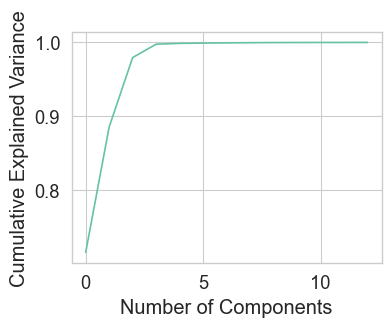

In [205]:
from sklearn.decomposition import PCA


pca = PCA(n_components=len(X.columns))
pca.fit(X)
X_pca = pca.transform(X)


explained_variance = pca.explained_variance_ratio_

# plot no of components vs cumulative explained variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(4, 3))
plt.plot(explained_variance, )
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()



By plotting the *Number of Components* against the *Cumulative Explained Variation*, we can see that 5 principal components are useful to explain 100% of the variance, the same number of numeric features. PCA won't provide the benefit of reducing dimensionality of the dataset.

In [206]:
from mpl_toolkits.mplot3d import Axes3D

nPCs = 3
pca = PCA(n_components=nPCs)
pca_result = pca.fit_transform(X_pca)

explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance: {explained_variance}")
# print(pca.components_)  # feature weight for each pc

# Convert it back to a DataFrame
pca_df = pd.DataFrame(data=pca_result, columns=["PC" + str(i + 1) for i in range(nPCs)])


X_oneHot_PCAed = pd.concat([pca_df, X_oneHot.drop(X_oneHot.columns, axis=1)], axis=1)

# print(X_oneHot_PCAed.columns)

Explained Variance: [0.71532104 0.17005023 0.09408364]


## Data Models

In [212]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

def cost_function(y_true, y_pred):
    return log_loss(y_true, y_pred)

### Naive Bayes

In [231]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

def naiveBayes_implement(nb_model, X_bayes, stringX):
    perfMetrics = ["accuracy","precision", "recall", "f1", "roc_auc"]
    nb_results = cross_validate(nb_model, X_bayes, Y, cv=5, scoring="f1", return_train_score=True)
    results_df = pd.DataFrame(nb_results)
    results_df.drop(columns=['fit_time', 'score_time'], inplace=True)  # Exclude fit_time and score_time
    print(f"{stringX} \n", results_df.mean(), "\n\n")

# Create empty lists to store the evaluation metrics
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

# Drop trestbpse col
X_noFbsTrestBps = X_numerical.copy().drop(["trestbps", "chol"], axis=1)
# Drop thalach
X_noThalach = X_numerical.copy().drop(["thalach"], axis=1)
# Drop fbs
X_noFbs = X_categorical.copy().drop(["fbs"], axis=1)

naiveBayes_implement(GaussianNB(), X, "X")
naiveBayes_implement(GaussianNB(), X_numerical, "X_numerical")
naiveBayes_implement(GaussianNB(), X_noFbsTrestBps, "X_noFbsTrestBps")
naiveBayes_implement(GaussianNB(), X_noThalach, "X_noThalach")
naiveBayes_implement(GaussianNB(), X_noFbs, "X_noFbs")

naiveBayes_implement(MultinomialNB(), X, "MultinomialNB")
naiveBayes_implement(BernoulliNB(), X, "BernoulliNB")

X 
 test_score     0.820722
train_score    0.840205
dtype: float64 


X_numerical 
 test_score     0.721304
train_score    0.738121
dtype: float64 


X_noFbsTrestBps 
 test_score     0.722886
train_score    0.724774
dtype: float64 


X_noThalach 
 test_score     0.679818
train_score    0.696167
dtype: float64 


X_noFbs 
 test_score     0.768878
train_score    0.788436
dtype: float64 


GaussianNB 
 test_score     0.820722
train_score    0.840205
dtype: float64 


MultinomialNB 
 test_score     0.731769
train_score    0.729547
dtype: float64 


BernoulliNB 
 test_score     0.748622
train_score    0.768797
dtype: float64 




score_time        0.007607
test_accuracy     0.744444
test_precision    0.736559
test_recall       0.846667
test_f1           0.784980
test_roc_auc      0.805278

### Logistic Regression

In [232]:
from sklearn.linear_model import LogisticRegression

# nb_results = cross_validate(LogisticRegression(), X_st, Y, cv=5, scoring=["accuracy", "precision", "recall", "f1", "neg_log_loss"])
# results_df = pd.DataFrame(nb_results)
# print("X_st", "\n", results_df.mean(), "\n\n")

# Sistema

nb_results = cross_validate(LogisticRegression(), X_oneHot_stand, Y, cv=5, scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])
results_df = pd.DataFrame(nb_results)
print("X_oneHot_stand","\n", results_df.mean(), "\n\n")

# nb_results = cross_validate(LogisticRegression(), X_oneHot_norm, Y, cv=5, scoring=["accuracy", "precision", "recall", "f1", "neg_log_loss"])
# results_df = pd.DataFrame(nb_results)
# print("X_oneHot_norm","\n", results_df.mean(), "\n\n")

param_grid = [    
    {
    'C' : [0.01,0.1,1,10,100],
    }
]

clf = GridSearchCV(LogisticRegression(), param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1, scoring=["accuracy", "precision", "recall", "f1", "roc_auc"], return_train_score=True, refit=False)
clf.fit(X_oneHot_stand, Y)
results_gs = pd.DataFrame(clf.cv_results_)
results_gs[['param_C','mean_test_accuracy','mean_test_precision','mean_test_recall','mean_test_f1','mean_test_roc_auc']]




X_oneHot_stand 
 fit_time          0.017602
score_time        0.025600
test_accuracy     0.847729
test_precision    0.875974
test_recall       0.766667
test_f1           0.817312
test_roc_auc      0.912155
dtype: float64 


Fitting 5 folds for each of 5 candidates, totalling 25 fits


,param_C,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_roc_auc
0,0.01,0.836478,0.907442,0.708333,0.794453,0.909732
1,0.1,0.851433,0.881055,0.775000,0.823610,0.915192
2,1,0.847729,0.875974,0.766667,0.817312,0.912155
3,10,0.844095,0.861543,0.775000,0.815554,0.904387
4,100,0.851502,0.865260,0.791667,0.826353,0.903295


# K-Nearest Neighbors

In [233]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Ensure X_oneHot_stand and Y are properly defined

param_grid = {"n_neighbors": np.linspace(1, 30).astype(int)}

# Choose a single scoring metric (e.g., "accuracy") for refit
refit_metric = "f1"

clf = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    cv=5,
    scoring=["accuracy", "precision", "recall", "f1", "roc_auc"],
    return_train_score=True,
    refit=refit_metric
)

clf.fit(X_oneHot_stand, Y)

results_gs = pd.DataFrame(clf.cv_results_)
results_subset = results_gs[
    ["param_n_neighbors", f"mean_test_{refit_metric}", f"mean_train_{refit_metric}"]
]
print(results_subset)


   param_n_neighbors  mean_test_f1  mean_train_f1
0                  1      0.726856       1.000000
1                  1      0.726856       1.000000
2                  2      0.689418       0.849756
3                  2      0.689418       0.849756
4                  3      0.797624       0.884308
5                  3      0.797624       0.884308
6                  4      0.768972       0.851020
7                  5      0.784420       0.858944
8                  5      0.784420       0.858944
9                  6      0.759680       0.857965
10                 6      0.759680       0.857965
11                 7      0.761076       0.853707
12                 8      0.767546       0.826490
13                 8      0.767546       0.826490
14                 9      0.779142       0.828030
15                 9      0.779142       0.828030
16                10      0.769164       0.818446
17                11      0.771479       0.814554
18                11      0.771479       0.814554


# Decision Trees

In [234]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

X_DT = X[["thalach", "oldpeak", "ca", "exang"]].copy()

clf = GridSearchCV(DecisionTreeClassifier(), {"max_depth": [1, 3, 5, 7, 9]}, cv=5, scoring=["accuracy", "precision", "recall", "f1", "roc_auc"], return_train_score=True, refit=False)
clf.fit(X, Y)
results_gs = pd.DataFrame(clf.cv_results_)
results_gs[['param_max_depth','mean_train_accuracy','mean_train_precision','mean_train_recall','mean_train_f1','mean_train_roc_auc', 'mean_test_accuracy','mean_test_precision','mean_test_recall','mean_test_f1','mean_test_roc_auc']]


,param_max_depth,mean_train_accuracy,mean_train_precision,mean_train_recall,mean_train_f1,mean_train_roc_auc,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_roc_auc
0,1,0.770444,0.743363,0.741667,0.742228,0.767626,0.732355,0.711954,0.691667,0.699324,0.728247
1,3,0.858730,0.867383,0.810417,0.836701,0.911335,0.769811,0.766765,0.691667,0.724813,0.804995
2,5,0.946098,0.978198,0.900000,0.937046,0.981375,0.743746,0.719208,0.700000,0.706038,0.743745
3,7,0.984190,0.997778,0.966667,0.981885,0.998722,0.747379,0.714366,0.725000,0.718494,0.749588
4,9,0.998140,0.997917,0.997917,0.997917,0.999939,0.751153,0.725349,0.716667,0.717543,0.746786
